Bayesian Statistics Made Simple
===

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2016 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import matplotlib.pyplot as plt

In [2]:
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.

    d: dictionary
    options: keyword args to add to d
    
    returns: modified d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

In [3]:
class Pmf(pd.Series):
    """Represents a probability Mass Function (PMF)."""

    def __init__(self, *args, **kwargs):
        """Initialize a Series.

        Note: this cleans up a weird Series behavior, which is
        that Series() and Series([]) yield different results.
        See: https://github.com/pandas-dev/pandas/issues/16737
        """
        if args:
            super().__init__(*args, **kwargs)
        else:
            underride(kwargs, dtype=np.float64)
            super().__init__([], **kwargs)
            
    @property
    def qs(self):
        """Get the quantities.
        
        returns: NumPy array
        """
        return self.index.values

    @property
    def ps(self):
        """Get the probabilities.
        
        returns: NumPy array
        """
        return self.values
            
    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()

### Working with Pmfs

Create a Pmf object to represent a six-sided die.

In [4]:
d6 = Pmf()

A Pmf is a map from possible outcomes to their probabilities.

In [5]:
for x in [1,2,3,4,5,6]:
    d6[x] = 1

Initially the probabilities don't add up to 1.

In [6]:
d6

,probs
1,1
2,1
3,1
4,1
5,1
6,1


`normalize` adds up the probabilities and divides through.  The return value is the total probability before normalizing.

In [7]:
def normalize(self):
    """Make the probabilities add up to 1 (modifies self).
    
    returns: normlizing constant
    """
    total = self.sum()
    self /= total
    return total

Pmf.normalize = normalize

In [8]:
d6.normalize()

6

Now the Pmf is normalized.

In [9]:
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


And we can compute its mean (which only works if it's normalized).

In [10]:
def mean(self):
    """Computes expected value.
    
    returns: float
    """
    return np.sum(self.ps * self.qs)

Pmf.mean = mean

In [11]:
d6.mean()

3.5

`choice` chooses a random values from the Pmf.

In [12]:
def choice(self, **options):
    """Makes a random choice.
    
    options: same as np.random.choice
    
    returns: NumPy array
    """
    options['p'] = self.ps
    return np.random.choice(self.qs, **options)

Pmf.choice = choice

In [13]:
d6.choice(size=10)

array([5, 2, 2, 1, 3, 2, 4, 4, 1, 3], dtype=int64)

`bar` plots the Pmf as a bar chart

In [14]:
def bar(self, **options):
    """Makes a bar plot.
    
    options: same as plt.bar
    """
    underride(options, label=self.name)
    plt.bar(self.qs, self.ps, **options)

Pmf.bar = bar

In [15]:
def decorate_dice(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('PMF')
    plt.title(title)

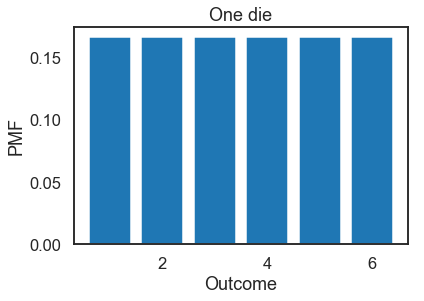

In [16]:
d6.bar()
decorate_dice('One die')

**Exercise 1:**  Suppose we roll two 6-sided dice and add them up.  The following function computes the `Pmf` of the sum.

It uses an outer sum and an outer product in a non-obvious way.  You don't have to understand how it works, but you might find it interesting.

In [17]:
def pmf_add(pmf1, pmf2):
    """Distribution of the sum.

    pmf1: Pmf
    pmf2: Pmf

    returns: new Pmf
    """
    qs = np.add.outer(pmf1.qs, pmf2.qs).flatten()
    ps = np.multiply.outer(pmf1.ps, pmf2.ps).flatten()
    series = pd.Series(ps).groupby(qs).sum()
    return Pmf(series)

By defining `__add__`, we can use the `+` operator to "add" two `Pmf` objects.

In [18]:
def __add__(self, x):
    """Computes the Pmf of the sum of values drawn from self and x.

    x: another Pmf or a scalar

    returns: new Pmf
    """
    if isinstance(x, Pmf):
        return pmf_add(self, x)
    else:
        return Pmf(self.qs + x, self.ps)

Pmf.__add__ = __add__
Pmf.__radd__ = __add__

Compute the distribution of the sum, plot it, and compute its mean.

In [74]:
pmf1 = Pmf()
pmf2 = Pmf()
for x in [1,2,3,4,5,6]:
    pmf1[x] = 1
    pmf2[x] = 1

In [75]:
pmf_sum = pmf1+pmf2

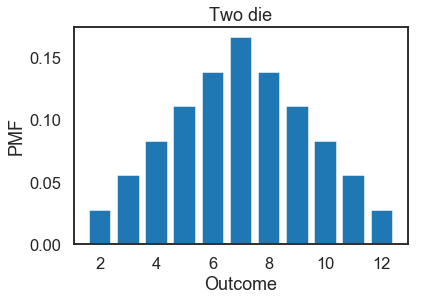

In [76]:
pmf_sum.normalize()
pmf_sum.bar()
decorate_dice('Two die')

In [77]:
pmf_sum.mean()

6.999999999999998

Quiz 6 code

In [78]:
print(pmf_sum[2]*100, pmf_sum[12]*100)

2.7777777777777777 2.7777777777777777


In [79]:
pmf_sum[7] = 0
pmf_sum.normalize()
print(pmf_sum[2]*100, pmf_sum[12]*100)

3.3333333333333335 3.3333333333333335


**Exercise 2:** Suppose I roll two dice and tell you the result is greater than 3.

Plot the Pmf of the remaining possible outcomes and compute its mean.

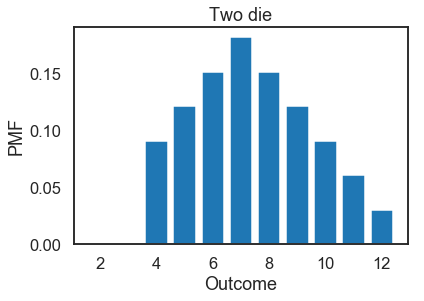

In [23]:
pmf_sum[2] = 0
pmf_sum[3] = 0
pmf_sum.normalize()
pmf_sum.bar()
decorate_dice('Two die')

In [24]:
pmf_sum.mean()

7.393939393939394

Posterior distribution given result is greater than 3. 

### The cookie problem

The following function make a `Pmf` object from a sequence of values.

In [25]:
def pmf_from_seq(seq, normalize=True, sort=True, **options):
    """Make a PMF from a sequence of values.
    
    seq: any kind of sequence
    normalize: whether to normalize the Pmf, default True
    sort: whether to sort the Pmf by values, default True
    options: passed to the pd.Series constructor
    
    returns: Pmf object
    """
    series = pd.Series(seq).value_counts(sort=False)
    
    options['copy'] = False
    pmf = Pmf(series, **options)
    
    if sort:
        pmf.sort_index(inplace=True)

    if normalize:
        pmf.normalize()
    
    return pmf

We'll use `pmf_from_seq` to create a Pmf with two equally likely hypotheses.

In [26]:
cookie = pmf_from_seq(['Bowl 1', 'Bowl 2'])
cookie

,probs
Bowl 1,0.5
Bowl 2,0.5


Then update each hypothesis with the likelihood of the data (a vanilla cookie).

In [27]:
cookie['Bowl 1'] *= 0.75
cookie['Bowl 2'] *= 0.5
cookie.normalize()

0.625

And display the posterior probabilities.

In [28]:
cookie

,probs
Bowl 1,0.6
Bowl 2,0.4


**Exercise 3:** Suppose we put the first cookie back, stir, choose again from the same bowl, and get a chocolate cookie.  What are the posterior probabilities after the second cookie?

Hint: The posterior (after the first cookie) becomes the prior (before the second cookie).

In [29]:
cookie['Bowl 1'] *= 0.25
cookie['Bowl 2'] *= 0.5
cookie.normalize()

0.35

In [30]:
cookie

,probs
Bowl 1,0.428571
Bowl 2,0.571429


**Exercise 4:** Instead of doing two updates, what if we collapse the two pieces of data into one update?

Re-initialize `Pmf` with two equally likely hypotheses and perform one update based on two pieces of data, a vanilla cookie and a chocolate cookie.

The result should be the same regardless of how many updates you do (or the order of updates).

In [31]:
cookie2 = pmf_from_seq(['Bowl 1', 'Bowl 2'])

In [32]:
cookie2['Bowl 1'] *= 0.75*0.25
cookie2['Bowl 2'] *= 0.5*0.5
cookie2.normalize()

0.21875

In [33]:
cookie2

,probs
Bowl 1,0.428571
Bowl 2,0.571429


### The dice problem

Create a Suite to represent dice with different numbers of sides.

In [34]:
pmf = pmf_from_seq([4, 6, 8, 12])
pmf

,probs
4,0.25
6,0.25
8,0.25
12,0.25


**Exercise 5:** We'll solve this problem two ways.  First we'll do it "by hand", as we did with the cookie problem; that is, we'll multiply each hypothesis by the likelihood of the data, and then renormalize.

In the space below, update `pmf` based on the likelihood of the data (rolling a 6), then normalize and print the results.

In [35]:
pmf[4] *= 0
pmf[6] *= (1/6)
pmf[8] *= (1/8)
pmf[12] *= (1/12)
pmf.normalize()

0.09374999999999999

In [36]:
pmf

,probs
4,0.000000
6,0.444444
8,0.333333
12,0.222222


**Exercise 6:**  Now let's do the same calculation using `update`, which encodes the structure of a Bayesian update:

In [37]:
def update(self, likelihood, data):
    """Bayesian update.
    
    likelihood: function that takes (data, hypo) and returns
                likelihood of data under hypo
    data: whatever format like_func understands
    
    returns: normalizing constant
    """
    for hypo in self.qs:
        self[hypo] *= likelihood(data, hypo)
        
    return self.normalize()

Pmf.update = update

Define a function called `likelihood_dice` that takes `data` and `hypo` and returns the probability of the data (the outcome of rolling the die) for a given hypothesis (number of sides on the die).

Hint: What should you do if the outcome exceeds the hypothetical number of sides on the die?

Here's an outline to get you started.

In [38]:
def likelihood_dice(data, hypo):
    """Likelihood function for the dice problem.
    
    data: outcome of the die roll
    hypo: number of sides
    
    returns: float probability
    """
    if data > hypo:
        return 0
    else:
        return (1/hypo) 

Now we can create a `Pmf` object and update it.

In [39]:
dice = pmf_from_seq([4, 6, 8, 12])
dice.update(likelihood_dice, 6)
dice

,probs
4,0.000000
6,0.444444
8,0.333333
12,0.222222


If we get more data, we can perform more updates.

In [40]:
for roll in [8, 7, 7, 5, 4]:
    dice.update(likelihood_dice, roll)

Here are the results.

In [41]:
dice

,probs
4,0.000000
6,0.000000
8,0.919294
12,0.080706


92% sure that it is the 8 sided dice

### The German tank problem

The German tank problem is actually identical to the dice problem.

In [42]:
def likelihood_tank(data, hypo):
    """Likelihood function for the tank problem.
    
    data: observed serial number
    hypo: number of tanks
    
    returns: float probability
    """
    if data > hypo:
        return 0
    else:
        return 1 / hypo

Here is the update after seeing Tank #42.

In [43]:
tank = pmf_from_seq(range(100))
tank.update(likelihood_tank, 42)
tank.mean()

66.32784309363326

And here's what the posterior distribution looks like.

In [44]:
def decorate_tank(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Number of tanks')
    plt.ylabel('PMF')
    plt.legend(loc='best')
    plt.title(title)

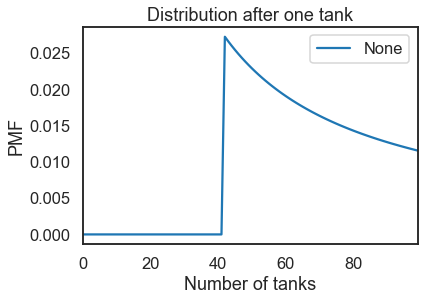

In [45]:
tank.plot()
decorate_tank('Distribution after one tank')

**Exercise 7:**  Suppose we see another tank with serial number 17.  What effect does this have on the posterior probabilities?

Update the `Pmf` with the new data and plot the results.

62.25994473449364


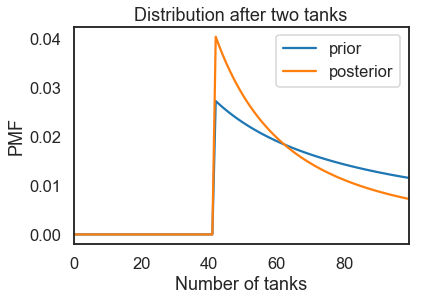

In [46]:
tank.plot(label='prior')
tank.update(likelihood_tank, 17)
print(tank.mean())
tank.plot(label='posterior')
decorate_tank('Distribution after two tanks')

### The Euro problem

**Exercise 8:**  Write a function called `likelihood_euro` that defines the likelihood function for the Euro problem.  Note that `hypo` is in the range 0 to 100.

Here's an outline to get you started.

In [47]:
def likelihood_euro(data, hypo):
    """ Likelihood function for the Euro problem.
    
    data: string, either 'H' or 'T'
    hypo: prob of heads (0-100)
    
    returns: float probability (0-1)
    """
    prob = hypo/100
    if data == 'H':
        return prob
    else:
        return 1-prob

Quiz 6 code

Flip coin twice and see whether outcomes are same or different. Find prob of data given hypo. Data is string: 'S' for same outcome and 'D' for different. 

Hypo is prob of heads from 0 to 1

In [85]:
def likelihood_coin(data, hypo):
    if data == 'S':
        return hypo**2+(1-hypo)**2
    else:
        return 2*hypo*(1-hypo)

In [86]:
likelihood_coin('D', 0.5)

0.5

Write a likelihood function that takes data and hypo and returns the probability of the data under the hypothesis, where:

1. data is a list of two values, k and n

2. hypo is your probability of getting a question right, p, from 0-1

In [ ]:
def likelihood_quiz(data, hypo):
    k = data[0]
    n = data[1]
    p = hypo
    return thinkstats2.EvalBinomialPmf(k, n, p)
    

Continuing with workshop:

In [48]:
likelihood_euro('H', 60)

0.6

For the prior, we'll start with a uniform distribution from 0 to 100.

In [49]:
def decorate_euro(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Probability of heads')
    plt.ylabel('PMF')
    plt.title(title)

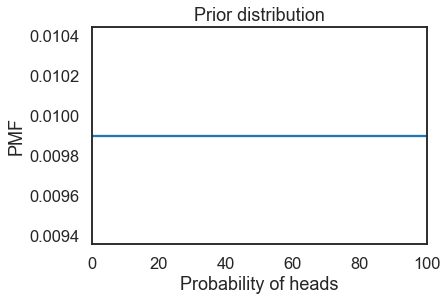

In [50]:
euro = pmf_from_seq(range(101))
euro.plot()
decorate_euro('Prior distribution')

Now we can update with a single heads:

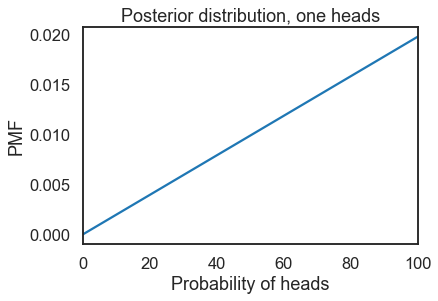

In [51]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, one heads')

Figure above after normalization

Another heads:

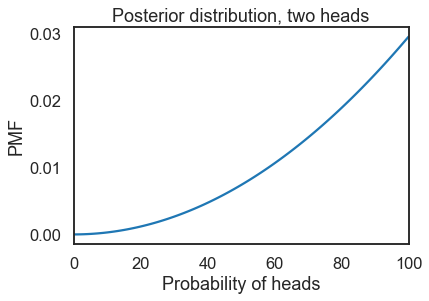

In [52]:
euro.update(likelihood_euro, 'H')
euro.plot()
decorate_euro('Posterior distribution, two heads')

More convinced that we have a high heads coin. Parabola (x^2)

And a tails:

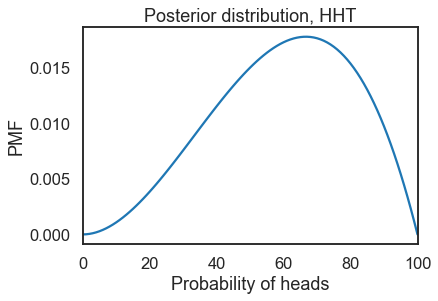

In [53]:
euro.update(likelihood_euro, 'T')
euro.plot()
decorate_euro('Posterior distribution, HHT')

Can't be a 100 probability of heads coin anymore. PMF of 100 is now 0. Peak is at 2/3 which is what we have 2 heads out of 3 tosses. Multiply parabola with line of 1-x (minus slope). Cubic spline. 

Starting over, here's what it looks like after 7 heads and 3 tails.

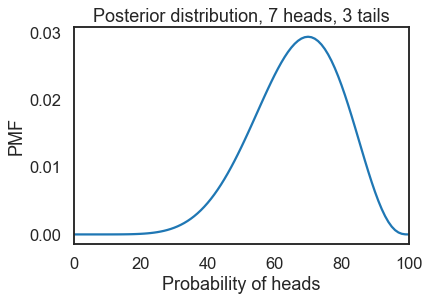

In [54]:
euro = pmf_from_seq(range(101))

for outcome in 'HHHHHHHTTT':
    euro.update(likelihood_euro, outcome)

euro.plot()
decorate_euro('Posterior distribution, 7 heads, 3 tails')

Distribution should get narrower, more confident of what prob of heads is. 

In [55]:
def MAP(self):
    """Maximum aposteori probability.
    
    returns: the value with the highest probability
    """
    return self.idxmax()

Pmf.MAP = MAP

In [56]:
euro.MAP()

70

Give peak of distribution, what is my best guess?

The maximum posterior probability is 70%, which is the observed proportion.

Here are the posterior probabilities after 140 heads and 110 tails.

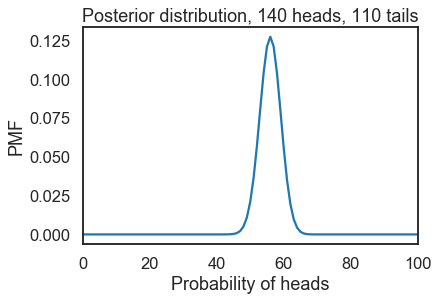

In [57]:
euro = pmf_from_seq(range(101))

evidence = 'H' * 140 + 'T' * 110
for outcome in evidence:
    euro.update(likelihood_euro, outcome)
    
euro.plot()

decorate_euro('Posterior distribution, 140 heads, 110 tails')

The posterior mean s about 56%

In [58]:
euro.mean()

55.95238095238095

So is the value with Maximum Aposteriori Probability (MAP).

In [59]:
euro.MAP()

56

mean close to MAP because distribution is symmetric

The posterior credible interval has a 90% chance of containing the true value (provided that the prior distribution truly represents our background knowledge).

In [60]:
from scipy.interpolate import interp1d

def quantile(self, ps):
    """Quantities corresponding to given probabilities.
    
    ps: sequence of probabilities
    
    return: sequence of quantities
    """
    cdf = self.sort_index().cumsum()
    interp = interp1d(cdf.values, cdf.index,
                      kind='next',
                      copy=False,
                      assume_sorted=True,
                      bounds_error=False,
                      fill_value=(self.qs[0], np.nan))
    return interp(ps)

Pmf.quantile = quantile

In [61]:
euro.quantile(0.5)

array(56.)

50% confidence interval

In [62]:
def credible_interval(self, p):
    """Credible interval containing the given probability.
    
    p: float 0-1
    
    returns: array of two quantities
    """
    tail = (1-p) / 2
    ps = [tail, 1-tail]
    return self.quantile(ps)

Pmf.credible_interval = credible_interval

In [63]:
euro.credible_interval(0.9)

array([51., 61.])

### Swamping the prior

The following function makes a Euro object with a triangle prior.

In [64]:
def TrianglePrior():
    """Makes a Suite with a triangular prior.
    """
    suite = Pmf(name='triangle')
    for x in range(0, 51):
        suite[x] = x
    for x in range(51, 101):
        suite[x] = 100-x 
    suite.normalize()
    return suite

And here's what it looks like:

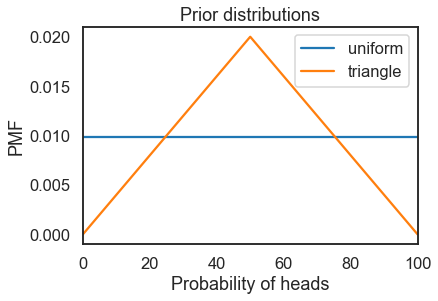

In [65]:
euro1 = pmf_from_seq(range(101), name='uniform')
euro1.plot()

euro2 = TrianglePrior()
euro2.plot()

plt.legend()
decorate_euro('Prior distributions')

**Exercise 9:** Update `euro1` and `euro2` with the same data we used before (140 heads and 110 tails) and plot the posteriors.  How big is the difference in the means?

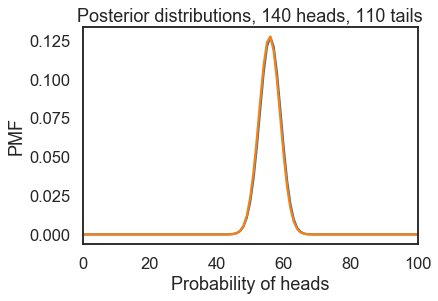

In [66]:
evidence = 'H' * 140 + 'T' * 110
for outcome in evidence:
    euro1.update(likelihood_euro, outcome)
    euro2.update(likelihood_euro, outcome)
    
euro1.plot()
euro2.plot()

decorate_euro('Posterior distributions, 140 heads, 110 tails')

In [67]:
print(euro1.mean(), euro2.mean())

55.95238095238095 55.74349943859505


The posterior distributions are not identical, but with this data, they converge to the point where there is no practical difference, for most purposes.